In [ ]:
# Install
!pip install torch torchvision torchaudio numpy matplotlib pytorch-ignite
!git clone https://github.com/d-li14/lambda.pytorch.git

In [ ]:
from lambda_pytorch import lambda_resnet
import torch
import torch.nn as nn
from math import log10

import os
from os import path as osp
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F

from ignite.metrics import PSNR
import scipy.io
from skimage.transform import resize
import numpy as np

from tqdm import tqdm

from skimage.metrics import peak_signal_noise_ratio


import os
import os.path
import numpy as np
import random
import h5py
import torch
import cv2
import glob
import torch.utils.data as udata
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Batch Size
BATCH_SIZE = 5

def display_tensor_image(result):
    im = transforms.ToPILImage()(result).convert("RGB")
    display(im)

def compute_avg_psnr(gt_img, output_img, data_range=1):
  gt_img = gt_img.detach().cpu().numpy().astype(np.float32)
  output_img = output_img.detach().cpu().numpy().astype(np.float32)
  PSNR=0
  for i in range(gt_img.shape[0]):
    PSNR += peak_signal_noise_ratio(output_img[i,:,:,:], gt_img[i,:,:,:], data_range=data_range)
  return PSNR/gt_img.shape[0]

def compute_avg_psnr_with_images(gt_img, output_img, input_img, data_range=1):
  input_img1 = input_img.detach().cpu().numpy().astype(np.float32)
  gt_img1 = gt_img.detach().cpu().numpy().astype(np.float32)
  output_img1 = output_img.detach().cpu().numpy().astype(np.float32)
  PSNR=0
  for i in range(gt_img.shape[0]):
    original_psnr = peak_signal_noise_ratio(input_img1[i,:,:,:], gt_img1[i,:,:,:], data_range=data_range)
    temp_psnr = peak_signal_noise_ratio(output_img1[i,:,:,:], gt_img1[i,:,:,:], data_range=data_range)
    PSNR += temp_psnr
    print("PSNR from input: " + str(original_psnr))
    print("Input: ")
    display_tensor_image(input_img[i,:,:,:])
    print("PSNR from output: " + str(temp_psnr))
    print("Output")
    display_tensor_image(output_img[i,:,:,:])
    print("Ground truth:")
    display_tensor_image(gt_img[i,:,:,:])
  return PSNR/gt_img.shape[0]

In [ ]:
# Get data in tensors for SIDD Medium without data augmentation
train_data=[]
val_data=[]
# Change to your own path
path = 'drive/MyDrive/SIDD_medium/'

for filename in os.listdir(path +'train'):
    image = Image.open(path + 'train/' + filename)
    image = image.resize((256, 256))
    image = ToTensor()(image) # unsqueeze to add artificial first dimension
    train_data.append(image)

for filename in os.listdir(path +'val'):
    image = Image.open(path + 'val/' + filename)
    image = image.resize((256, 256))
    image = ToTensor()(image) # unsqueeze to add artificial first dimension
    val_data.append(image)

In [ ]:
# # Preprocess testing data from mat file -> resize and move channel column to front as np -> convert to tensor
sidd_test_path = 'drive/MyDrive/SIDD_Data/'


benchmark_y = np.array(scipy.io.loadmat(sidd_test_path + 'ValidationGtBlocksSrgb.mat')['ValidationGtBlocksSrgb'])
benchmark_y = benchmark_y.reshape(-1, 256, 256, 3)
benchmark_val =[]
for y in benchmark_y:
  img = resize(y[:], (50, 50))
  img = np.moveaxis(img, -1, 0)
  benchmark_val.append(img)
benchmark_val = np.array(benchmark_val)

# benchmark_train = torch.from_numpy(benchmark_train)
benchmark_val = torch.from_numpy(benchmark_val)

# Load data into dataloader
BATCH_SIZE = 5

sidd_test_loader = DataLoader(benchmark_val, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
## Credit to ADNET https://github.com/hellloxiaotian/ADNet/blob/master/color/dataset.py

import os
import os.path
import numpy as np
import random
import h5py
import torch
import cv2
import glob
import torch.utils.data as udata
import torch
import torch.nn as nn

def data_augmentation(image, mode):
    out = np.transpose(image, (1,2,0))
    #out = image
    if mode == 0:
        # original
        out = out
    elif mode == 1:
        # flip up and down
        out = np.flipud(out)
    elif mode == 2:
        # rotate counterwise 90 degree
        out = np.rot90(out)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        out = np.rot90(out)
        out = np.flipud(out)
    elif mode == 4:
        # rotate 180 degree
        out = np.rot90(out, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        out = np.rot90(out, k=2)
        out = np.flipud(out)
    elif mode == 6:
        # rotate 270 degree
        out = np.rot90(out, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        out = np.rot90(out, k=3)
        out = np.flipud(out)
    return np.transpose(out, (2,0,1))
    #return out

def normalize(data):
    return data/255.

def Im2Patch(img, win, stride=1):
    k = 0
    endc = img.shape[0]
    #print endc
    endw = img.shape[1]
    endh = img.shape[2]
    patch = img[:, 0:endw-win+0+1:stride, 0:endh-win+0+1:stride]
    TotalPatNum = patch.shape[1] * patch.shape[2]
    Y = np.zeros([endc, win*win,TotalPatNum], np.float32)
    for i in range(win):
        for j in range(win):
            patch = img[:,i:endw-win+i+1:stride,j:endh-win+j+1:stride]
            Y[:,k,:] = np.array(patch[:]).reshape(endc, TotalPatNum)
            k = k + 1
    return Y.reshape([endc, win, win, TotalPatNum])

def prepare_data(data_path, test_data_path, patch_size, stride, train_bool=False, aug_times=1,  dim=(256,256)):
    # train
    if train_bool:
      print('process training data')
      scales = [1, 0.9, 0.8, 0.7]
      files = os.listdir(data_path)
      files.sort()
      h5f = h5py.File('train.h5', 'w')
      train_num = 0
      for i in range(len(files)):
          img = cv2.imread(data_path + '/' + files[i])
          img = cv2.resize(img, dim)
          h, w, c = img.shape
          for k in range(len(scales)):
              Img = cv2.resize(img, (int(h*scales[k]), int(w*scales[k])), interpolation=cv2.INTER_CUBIC)
              Img = torch.tensor(Img)
              Img = Img.permute(2,0,1)
              Img = Img.numpy()
              Img = np.float32(normalize(Img))
              patches = Im2Patch(Img, win=patch_size, stride=stride)
              print("file: %s scale %.1f # samples: %d" % (files[i], scales[k], patches.shape[3]*aug_times))
              for n in range(patches.shape[3]):
                  data = patches[:,:,:,n].copy()
                  h5f.create_dataset(str(train_num), data=data)
                  train_num += 1
                  for m in range(aug_times-1):
                      data_aug = data_augmentation(data, np.random.randint(1,8))
                      h5f.create_dataset(str(train_num)+"_aug_%d" % (m+1), data=data_aug)
                      train_num += 1
      h5f.close()
    # val
    print('\nprocess validation data')
    files = os.listdir(test_data_path)
    files.sort()
    h5f = h5py.File('val.h5', 'w')
    val_num = 0
    for i in range(len(files)):
        print("file: %s" % files[i])
        img = cv2.imread(test_data_path + '/' + files[i])
        img = cv2.resize(img, (50,50))
        img = torch.tensor(img)
        img = img.permute(2,0,1)
        img = img.numpy()
        img = np.float32(normalize(img))
        h5f.create_dataset(str(val_num), data=img)
        val_num += 1
    h5f.close()
    if train_bool:
      print('training set, # samples %d\n' % train_num)
    print('val set, # samples %d\n' % val_num)

class KodakDataset(udata.Dataset):
    def __init__(self, train=True):
        super(KodakDataset, self).__init__()
        self.train = train
        if self.train:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/train.h5', 'r')
        else:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/kodak_val.h5', 'r')
        self.keys = list(h5f.keys())
        random.shuffle(self.keys)
        h5f.close()
    def __len__(self):
        return len(self.keys)
    def __getitem__(self, index):
        if self.train:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/train.h5', 'r')
        else:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/kodak_val.h5', 'r')
        key = self.keys[index]
        data = np.array(h5f[key])
        h5f.close()
        return torch.Tensor(data)

class CBSDDataset(udata.Dataset):
    def __init__(self, train=True):
        super(CBSDDataset, self).__init__()
        self.train = train
        if self.train:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/train.h5', 'r')
        else:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/val.h5', 'r')
        self.keys = list(h5f.keys())
        random.shuffle(self.keys)
        h5f.close()
    def __len__(self):
        return len(self.keys)
    def __getitem__(self, index):
        if self.train:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/train.h5', 'r')
        else:
            h5f = h5py.File('drive/MyDrive/SIDD_medium_preprocessed/val.h5', 'r')
        key = self.keys[index]
        data = np.array(h5f[key])
        h5f.close()
        return torch.Tensor(data)

In [ ]:
# Get data in tensors
train_data=[]
val_data=[]
# # Change to your own path
path = 'drive/MyDrive/SIDD_medium/'
test_path = 'drive/MyDrive/Kodak24/original'

BATCH_SIZE = 5

dataset_train = KodakDataset(train=True)
dataset_val = KodakDataset(train=False)
dataset_cbsd_val = CBSDDataset(train=False)

train_loader = DataLoader(dataset=dataset_train, num_workers=4, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
kodak_test_loader = DataLoader(dataset=dataset_val, num_workers=4, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
cbsd_test_loader =  DataLoader(dataset=dataset_cbsd_val, num_workers=4, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=False)
# val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle=False)
  

In [ ]:
test_variation = 'noisy15'

In [ ]:
# Get data in tensors
test_data=[]
test_val_data=[]

# Change to your own path
path = 'drive/MyDrive/CBSD68/'
for filename in os.listdir(path + test_variation):
    image = Image.open(path + test_variation + '/' + filename)
    image = image.resize((50, 50))
    image = ToTensor()(image) # unsqueeze to add artificial first dimension
    test_data.append(image)

for filename in os.listdir(path + 'original'):
    image = Image.open(path + 'original/' + filename)
    image = image.resize((50, 50))
    image = ToTensor()(image) # unsqueeze to add artificial first dimension
    test_val_data.append(image)

test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False)
test_val_loader = DataLoader(test_val_data, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:

# Getting model and copying over pretrained
# weights from pretrained model
lambda_model = lambda_resnet.lambda_resnet50()
lambda_model.load_state_dict(torch.load('./drive/MyDrive/lambda-resnet50.pth'))

# Defining wrapper model
class LambdaDenoiser(nn.Module):
  patch_out = False
  def __init__(self):
    super(LambdaDenoiser, self).__init__()
    self.lm = lambda_model
    self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.lm.fc.out_features, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1028),
            torch.nn.ReLU(),
            torch.nn.Linear(1028, 3*50*50),
            torch.nn.Sigmoid()
        )
    

  def forward(self, x):
    outputs = self.lm.forward(x)
    decoded = self.decoder(outputs)
    return decoded.view(BATCH_SIZE, 3, 50, 50)

  def set_patch_out(self, patch_out_bool):
    patch_out = patch_out_bool

# Full model with decoder
model = LambdaDenoiser()

# Learning rate and other hyperparameters
LEARNING_RATE = 0.0001

# Loss function
loss_function = torch.nn.MSELoss()

criterion = loss_function

# SGD optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda()


In [ ]:
## Training WITHOUT preprocessing

def train(epoch):
  # Function to train with LambdaDenoiser backbone TODO
  model.train()
  training_loss = 0
  training_psnr = 0
  losses = 0

  for batch_index, images in enumerate(tqdm(train_loader)):

    for val_batch, val_image in enumerate(val_loader):
      if val_batch == batch_index:
        break
    
    optimizer.zero_grad()

    # X is each image
    x = np.split(np.squeeze(np.array(images)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    
    # Load into tensor of size (5, 3, 128, 128)
    x = torch.FloatTensor(x)
    
    images, val_image = x.to(device), val_image.to(device)
    outputs = model(images)
    #print(outputs)
    loss = criterion(outputs, val_image)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
    training_psnr +=compute_avg_psnr(val_image, outputs)
  print('Epoch: ' + str(epoch) + ', Training MSE Loss: ' + str(training_loss/(batch_index+1)) + ', Training PSNR: ' +  str(training_psnr/(batch_index+1)))
  return training_loss/(batch_index+1), training_psnr/(batch_index+1)

In [ ]:
## Training WITH Preprocessed data

noiseL = 15

def train(epoch, model, optimizer):
  # Function to train with VitDenoier backbone
  model.train()
  training_loss = 0
  training_psnr = 0

  for batch_index, images in enumerate(tqdm(train_loader)):
    optimizer.zero_grad()
    img_train = images
    mean = torch.zeros(img_train.size(), dtype=torch.float32)
    noise = torch.normal(mean=mean, std=noiseL/255.)
    imgn_train = torch.clamp(img_train + noise, 0., 1.)
    noise = Variable(noise.to(device))
    x = np.split(np.squeeze(np.array(imgn_train)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    model_input = torch.FloatTensor(x)
    model_input, val_images = Variable(model_input.to(device)), Variable(img_train.to(device))
    outputs = model(model_input)
    loss = criterion(outputs, val_images) 
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
    training_psnr +=compute_avg_psnr(val_images, outputs)
  print('Epoch: ' + str(epoch) + ', Training MSE Loss: ' + str(training_loss/(batch_index+1)) + ', Training PSNR: ' +  str(training_psnr/(batch_index+1)))
  return training_loss/(batch_index+1), training_psnr/(batch_index+1)

In [ ]:
## Testing WITHOUT Preprocessed data

def test():
    test_loss = 0
    test_psnr = 0
    total_images = 0
    correct_images = 0
    total_loss = 0
    model.eval()

    with torch.no_grad():
      for batch_index, images in enumerate(tqdm(test_loader)):
        for val_batch, val_images in enumerate(test_val_loader):
          if val_batch == batch_index:
            break

        #print(np.array(images).shape)
        #print(np.squeeze(np.array(images)).shape)
        try:
          x = np.split(np.squeeze(np.array(images)), BATCH_SIZE)
        except ValueError:
          print("Value Error")
          continue 


        for index, array in enumerate(x):
          x[index] = np.squeeze(array)

        
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        x = torch.FloatTensor(x)
        images, val_images = x.to(device), val_images.to(device)
        #print(val_images)
        outputs = model(images)
        psnr = peak_signal_noise_ratio(val_images.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        test_psnr += psnr
        test_loss += criterion(outputs, val_images).item()
    print('Epoch: ' + str(epoch) + ', Test MSE Loss: ' + str(test_loss/(batch_index+1)) + ', Test PSNR Loss: ' + str(test_psnr/(batch_index+1)))
    return test_loss/(batch_index+1),  test_psnr/(batch_index+1)

In [ ]:
## Testing WITH Preprocessed data

def test(test_loader, model):
    test_psnr = 0
    test_loss = 0
    model.eval()
    with torch.no_grad():
      for batch_index, images in enumerate(tqdm(test_loader)): 
        img_test = images
        mean = torch.zeros(img_test.size(), dtype=torch.float32)
        noise = torch.normal(mean=mean, std=noiseL/255.)
        imgn_test = torch.clamp(img_test + noise, 0., 1.)
        noise = Variable(noise.to(device))
        x = np.split(np.squeeze(np.array(imgn_test)), BATCH_SIZE)
        # Remove unecessary dimension
        for index, array in enumerate(x):
          x[index] = np.squeeze(array)
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        model_input = torch.FloatTensor(x)
        model_input, val_images =  Variable(model_input.to(device)),  Variable(img_test.to(device))
        outputs = model(model_input)
        psnr = compute_avg_psnr(val_images, outputs)
        test_psnr += psnr
        test_loss += criterion(outputs, val_images).item()
    print('Epoch: ' + str(epoch) + ', Test MSE Loss: ' + str(test_loss/(batch_index+1)) + ', Test PSNR: ' + str(test_psnr/(batch_index+1)))
    return test_loss/(batch_index+1),  test_psnr/(batch_index+1)

In [ ]:
def test_with_images(num_batches=5):
    test_psnr = 0
    test_loss = 0
    model.eval()
    i=0
    with torch.no_grad():
      for batch_index, images in enumerate(tqdm(sidd_test_loader)): 
        img_test = images
        mean = torch.zeros(img_test.size(), dtype=torch.float32)
        noise = torch.normal(mean=mean, std=noiseL/255.)
        imgn_test = torch.clamp(img_test + noise, 0., 1.)
        noise = Variable(noise.to(device))
        x = np.split(np.squeeze(np.array(imgn_test)), BATCH_SIZE)
        # Remove unecessary dimension
        for index, array in enumerate(x):
          x[index] = np.squeeze(array)
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        model_input = torch.FloatTensor(x)
        model_input, val_images =  Variable(model_input.to(device)),  Variable(img_test.to(device))
        outputs = model(model_input)
        psnr = compute_avg_psnr_with_images(val_images, outputs, imgn_test)
        test_psnr += psnr
        test_loss += criterion(outputs, val_images).item()
        i+=1
        if i >= num_batches:
          break
    print('Epoch: ' + str(epoch) + ', Test MSE Loss: ' + str(test_loss/(batch_index+1)) + ', Test PSNR: ' + str(test_psnr/(batch_index+1)))
    return test_loss/(batch_index+1),  test_psnr/(batch_index+1)

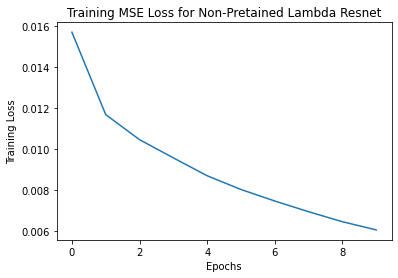

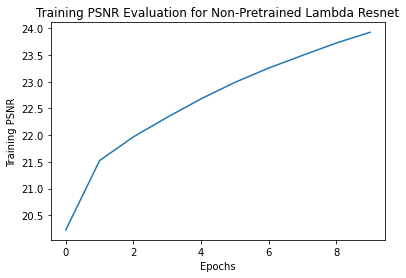

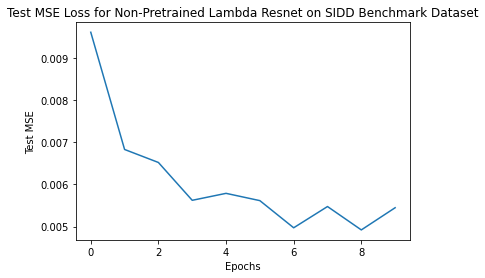

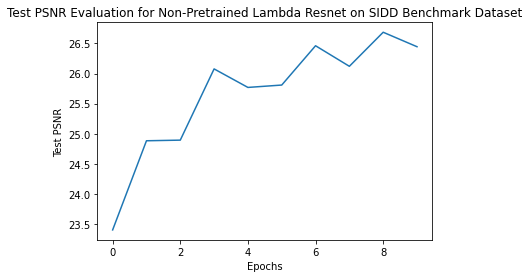

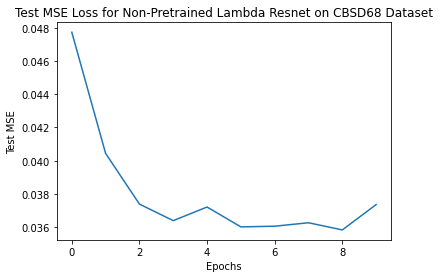

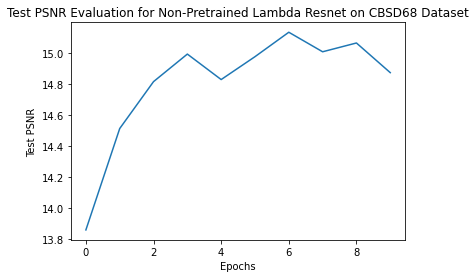

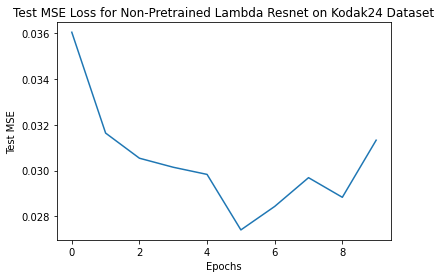

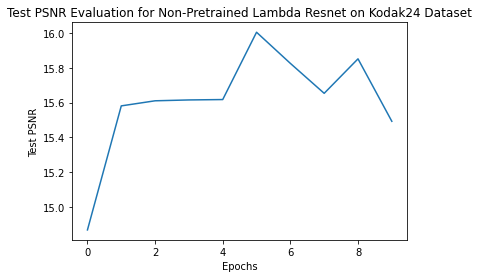

In [ ]:
epochs = [i for i in range(0, 10)]
plt.plot(epochs, trn_loss)
plt.title("Training MSE Loss for Non-Pretained Lambda Resnet")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

plt.plot(epochs, trn_psnr)
plt.title("Training PSNR Evaluation for Non-Pretrained Lambda Resnet")
plt.xlabel("Epochs")
plt.ylabel("Training PSNR")
plt.show()

plt.plot(epochs, sidd_tst_loss)
plt.title("Test MSE Loss for Non-Pretrained Lambda Resnet on SIDD Benchmark Dataset")
plt.xlabel("Epochs")
plt.ylabel("Test MSE")
plt.show()

plt.plot(epochs, sidd_tst_psnr)
plt.title("Test PSNR Evaluation for Non-Pretrained Lambda Resnet on SIDD Benchmark Dataset")
plt.xlabel("Epochs")
plt.ylabel("Test PSNR")
plt.show()

plt.plot(epochs, cbsd_tst_loss)
plt.title("Test MSE Loss for Non-Pretrained Lambda Resnet on CBSD68 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Test MSE")
plt.show()

plt.plot(epochs, cbsd_tst_psnr)
plt.title("Test PSNR Evaluation for Non-Pretrained Lambda Resnet on CBSD68 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Test PSNR")
plt.show()

plt.plot(epochs, kodak_tst_loss)
plt.title("Test MSE Loss for Non-Pretrained Lambda Resnet on Kodak24 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Test MSE")
plt.show()

plt.plot(epochs, kodak_tst_psnr)
plt.title("Test PSNR Evaluation for Non-Pretrained Lambda Resnet on Kodak24 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Test PSNR")
plt.show()

In [ ]:
trn_loss = []
trn_psnr = []
sidd_tst_loss = []
sidd_tst_psnr = []
cbsd_tst_loss = []
cbsd_tst_psnr = []
kodak_tst_loss = []
kodak_tst_psnr = []

models = []

model.to(device)
    
#RETURN LOSS AFTER EACH EPOCH
for epoch in range(10):
    epoch_loss, epoch_psnr = train(epoch, model, optimizer)
    trn_loss.append(epoch_loss)
    trn_psnr.append(epoch_psnr)
    models.append(model)
    t_epoch_loss, t_epoch_psnr = test(sidd_test_loader, model)
    sidd_tst_loss.append(t_epoch_loss)
    sidd_tst_psnr.append(t_epoch_psnr)
    t_epoch_loss, t_epoch_psnr = test(cbsd_test_loader, model)
    cbsd_tst_loss.append(t_epoch_loss)
    cbsd_tst_psnr.append(t_epoch_psnr)
    t_epoch_loss, t_epoch_psnr = test(kodak_test_loader, model)
    kodak_tst_loss.append(t_epoch_loss)
    kodak_tst_psnr.append(t_epoch_psnr)

100%|██████████| 5952/5952 [10:57<00:00,  9.05it/s]


Epoch: 0, Training MSE Loss: 0.0158159398390556, Training PSNR: 20.216705641035507


100%|██████████| 256/256 [00:08<00:00, 31.20it/s]


Epoch: 0, Test MSE Loss: 0.009677411965565244, Test PSNR: 23.249350765505145


100%|██████████| 13/13 [00:00<00:00, 18.27it/s]


Epoch: 0, Test MSE Loss: 0.049732476472854614, Test PSNR: 13.772678157046018


100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Epoch: 0, Test MSE Loss: 0.040889667347073555, Test PSNR: 14.521463231383416


100%|██████████| 5952/5952 [10:57<00:00,  9.06it/s]


Epoch: 1, Training MSE Loss: 0.012099682969350671, Training PSNR: 21.395402956039167


100%|██████████| 256/256 [00:08<00:00, 31.68it/s]


Epoch: 1, Test MSE Loss: 0.008053624467806855, Test PSNR: 24.005286897775207


100%|██████████| 13/13 [00:00<00:00, 18.11it/s]


Epoch: 1, Test MSE Loss: 0.04339406037559876, Test PSNR: 14.132318467912597


100%|██████████| 4/4 [00:00<00:00, 11.21it/s]


Epoch: 1, Test MSE Loss: 0.03645062632858753, Test PSNR: 14.745925885219389


100%|██████████| 5952/5952 [10:57<00:00,  9.05it/s]


Epoch: 2, Training MSE Loss: 0.010755151794353057, Training PSNR: 21.897371943556788


100%|██████████| 256/256 [00:08<00:00, 31.34it/s]


Epoch: 2, Test MSE Loss: 0.0065908777677896975, Test PSNR: 24.862212961929277


100%|██████████| 13/13 [00:00<00:00, 18.72it/s]


Epoch: 2, Test MSE Loss: 0.0382801338743705, Test PSNR: 14.789994903376938


100%|██████████| 4/4 [00:00<00:00, 11.33it/s]


Epoch: 2, Test MSE Loss: 0.03070963639765978, Test PSNR: 15.669374240012381


100%|██████████| 5952/5952 [10:50<00:00,  9.15it/s]


Epoch: 3, Training MSE Loss: 0.00988089459806165, Training PSNR: 22.224619898953488


100%|██████████| 256/256 [00:08<00:00, 31.93it/s]


Epoch: 3, Test MSE Loss: 0.006725460505847278, Test PSNR: 24.769965969957674


100%|██████████| 13/13 [00:00<00:00, 18.57it/s]


Epoch: 3, Test MSE Loss: 0.040452113518348105, Test PSNR: 14.469113945667512


100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


Epoch: 3, Test MSE Loss: 0.0328707997687161, Test PSNR: 15.34797136258906


100%|██████████| 5952/5952 [10:59<00:00,  9.02it/s]


Epoch: 4, Training MSE Loss: 0.009074761992901243, Training PSNR: 22.556138028432933


100%|██████████| 256/256 [00:08<00:00, 30.84it/s]


Epoch: 4, Test MSE Loss: 0.0064612620444921085, Test PSNR: 24.829055896781107


100%|██████████| 13/13 [00:00<00:00, 18.36it/s]


Epoch: 4, Test MSE Loss: 0.03698923467443539, Test PSNR: 14.870442906268464


100%|██████████| 4/4 [00:00<00:00, 10.38it/s]


Epoch: 4, Test MSE Loss: 0.030703162774443626, Test PSNR: 15.525126506303309


100%|██████████| 5952/5952 [11:00<00:00,  9.00it/s]


Epoch: 5, Training MSE Loss: 0.008341054098730061, Training PSNR: 22.862968096344005


100%|██████████| 256/256 [00:08<00:00, 31.07it/s]


Epoch: 5, Test MSE Loss: 0.0052269810849912965, Test PSNR: 26.413202069578134


100%|██████████| 13/13 [00:00<00:00, 18.46it/s]


Epoch: 5, Test MSE Loss: 0.036341399097671874, Test PSNR: 14.97619982676633


100%|██████████| 4/4 [00:00<00:00, 10.97it/s]


Epoch: 5, Test MSE Loss: 0.030022434424608946, Test PSNR: 15.668664110931587


100%|██████████| 5952/5952 [11:02<00:00,  8.99it/s]


Epoch: 6, Training MSE Loss: 0.007649716347073717, Training PSNR: 23.181452759754265


100%|██████████| 256/256 [00:08<00:00, 31.51it/s]


Epoch: 6, Test MSE Loss: 0.005129272713180232, Test PSNR: 26.26889431296029


100%|██████████| 13/13 [00:00<00:00, 18.39it/s]


Epoch: 6, Test MSE Loss: 0.03627145562607508, Test PSNR: 15.004764884527216


100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


Epoch: 6, Test MSE Loss: 0.028202244080603123, Test PSNR: 15.861661294124257


100%|██████████| 5952/5952 [11:01<00:00,  9.00it/s]


Epoch: 7, Training MSE Loss: 0.007097098706596029, Training PSNR: 23.422784421166057


100%|██████████| 256/256 [00:08<00:00, 31.08it/s]


Epoch: 7, Test MSE Loss: 0.005109823049289927, Test PSNR: 26.241621799004605


100%|██████████| 13/13 [00:00<00:00, 18.00it/s]


Epoch: 7, Test MSE Loss: 0.035372515997061364, Test PSNR: 15.144906416612066


100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


Epoch: 7, Test MSE Loss: 0.027567979879677296, Test PSNR: 15.924503779226487


100%|██████████| 5952/5952 [11:00<00:00,  9.02it/s]


Epoch: 8, Training MSE Loss: 0.006611392287370735, Training PSNR: 23.647819821678127


100%|██████████| 256/256 [00:08<00:00, 31.95it/s]


Epoch: 8, Test MSE Loss: 0.0056104589742660155, Test PSNR: 25.459005673983388


100%|██████████| 13/13 [00:00<00:00, 19.02it/s]


Epoch: 8, Test MSE Loss: 0.0363886715987554, Test PSNR: 14.954544916029722


100%|██████████| 4/4 [00:00<00:00, 10.96it/s]


Epoch: 8, Test MSE Loss: 0.02986980089917779, Test PSNR: 15.5902438275469


100%|██████████| 5952/5952 [10:57<00:00,  9.05it/s]


Epoch: 9, Training MSE Loss: 0.006169073130877223, Training PSNR: 23.864644956063252


100%|██████████| 256/256 [00:08<00:00, 31.16it/s]


Epoch: 9, Test MSE Loss: 0.005444273410868724, Test PSNR: 26.39688964249935


100%|██████████| 13/13 [00:00<00:00, 18.48it/s]


Epoch: 9, Test MSE Loss: 0.037880358644402944, Test PSNR: 14.786906093054776


100%|██████████| 4/4 [00:00<00:00, 11.03it/s]

Epoch: 9, Test MSE Loss: 0.028510919772088528, Test PSNR: 15.844881018427092


  0%|          | 0/256 [00:00<?, ?it/s]

PSNR from input: 24.741572011323903
Input: 


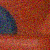

PSNR from output: 18.464491164877703
Output


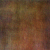

Ground truth:


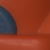

PSNR from input: 24.68572964711989
Input: 


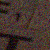

PSNR from output: 27.25459253151722
Output


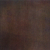

Ground truth:


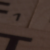

PSNR from input: 24.576425795189543
Input: 


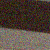

PSNR from output: 22.873867614168613
Output


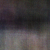

Ground truth:


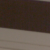

PSNR from input: 24.593100907294133
Input: 


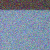

PSNR from output: 20.709553742125422
Output


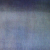

Ground truth:


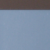

PSNR from input: 25.428736764839268
Input: 


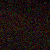

PSNR from output: 36.98918203117784
Output


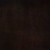

Ground truth:


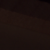

  0%|          | 1/256 [00:00<00:39,  6.53it/s]

PSNR from input: 24.62836315114904
Input: 


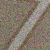

PSNR from output: 22.56781705807787
Output


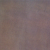

Ground truth:


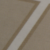

PSNR from input: 24.576067567440735
Input: 


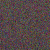

PSNR from output: 36.25020801448537
Output


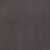

Ground truth:


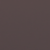

PSNR from input: 24.671950655838582
Input: 


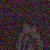

PSNR from output: 31.554308308343835
Output


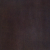

Ground truth:


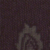

PSNR from input: 24.504226768339738
Input: 


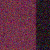

PSNR from output: 23.3947312136789
Output


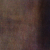

Ground truth:


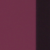

PSNR from input: 24.67821212783454
Input: 


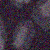

PSNR from output: 24.036171295322355
Output


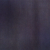

Ground truth:


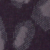

  1%|          | 2/256 [00:00<00:36,  6.99it/s]

PSNR from input: 24.619724679232718
Input: 


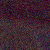

PSNR from output: 29.90296628066012
Output


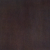

Ground truth:


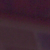

PSNR from input: 24.63432294493589
Input: 


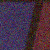

PSNR from output: 25.377930795417917
Output


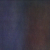

Ground truth:


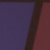

PSNR from input: 24.732894183659916
Input: 


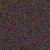

PSNR from output: 36.13750887866593
Output


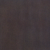

Ground truth:


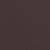

PSNR from input: 25.146703375541165
Input: 


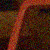

PSNR from output: 20.196527307727543
Output


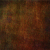

Ground truth:


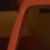

PSNR from input: 24.52706926655949
Input: 


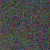

PSNR from output: 32.574488240928765
Output


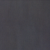

Ground truth:


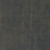

  1%|          | 3/256 [00:00<00:36,  6.91it/s]

PSNR from input: 26.155632462603165
Input: 


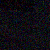

PSNR from output: 36.88241573652657
Output


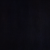

Ground truth:


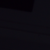

PSNR from input: 24.919626097095183
Input: 


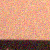

PSNR from output: 14.70132896437075
Output


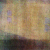

Ground truth:


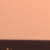

PSNR from input: 24.700094946068315
Input: 


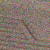

PSNR from output: 25.777571578172356
Output


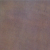

Ground truth:


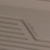

PSNR from input: 24.535631603945284
Input: 


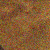

PSNR from output: 24.98815888537278
Output


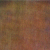

Ground truth:


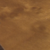

PSNR from input: 24.595101265383374
Input: 


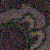

PSNR from output: 24.242356805779565
Output


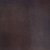

Ground truth:


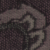

  2%|▏         | 4/256 [00:00<00:37,  6.74it/s]

PSNR from input: 24.80478226255643
Input: 


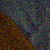

PSNR from output: 25.19964197564387
Output


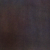

Ground truth:


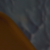

PSNR from input: 24.63633742593306
Input: 


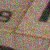

PSNR from output: 20.47702251578087
Output


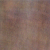

Ground truth:


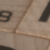

PSNR from input: 24.628413412885628
Input: 


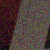

PSNR from output: 24.629920042361615
Output


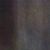

Ground truth:


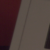

PSNR from input: 24.574586222196757
Input: 


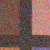

PSNR from output: 19.904736238650024
Output


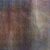

Ground truth:


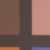

PSNR from input: 24.641780837728128
Input: 


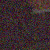

PSNR from output: 30.67082180670292
Output


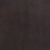

Ground truth:


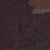

  2%|▏         | 4/256 [00:00<00:45,  5.48it/s]

Epoch: 9, Test MSE Loss: 0.0051763347084695455, Test PSNR: 26.23033276106147


(0.0051763347084695455, 26.23033276106147)

In [ ]:
test_with_images()

In [ ]:
# Epoch iterations without mse and psnr for both 
# testing and training

trn_loss = []
tst_loss = []
model.to(device)
  
num_epochs = 30

#RETURN LOSS AFTER EACH EPOCH
for epoch in range(num_epochs):
    #epoch_loss = train(epoch)
    #trn_loss.append(epoch_loss)
    tst_loss.append(test())
    
print(trn_loss)

In [ ]:
trn_loss = []
trn_psnr = []
tst_loss = []
tst_psnr = []
model.to(device)
    
num_epochs = 10
#RETURN LOSS AFTER EACH EPOCH
for epoch in range(num_epochs):
    epoch_loss, epoch_psnr = train(epoch)
    trn_loss.append(epoch_loss)
    trn_psnr.append(epoch_psnr)
    t_epoch_loss, t_epoch_psnr = test()
    tst_loss.append(t_epoch_loss)
    tst_psnr.append(t_epoch_psnr)


100%|██████████| 5952/5952 [07:15<00:00, 13.66it/s]


Epoch: 0, Training MSE Loss: 0.03497253361501373, Training PSNR: 16.870481817234104


100%|██████████| 256/256 [00:05<00:00, 46.42it/s]


Epoch: 0, Test MSE Loss: 0.020851293446045076, Test PSNR Loss: 19.15584116041167


100%|██████████| 5952/5952 [07:20<00:00, 13.52it/s]


Epoch: 1, Training MSE Loss: 0.023608264556539218, Training PSNR: 18.466808018519185


100%|██████████| 256/256 [00:05<00:00, 46.05it/s]


Epoch: 1, Test MSE Loss: 0.020077020038090514, Test PSNR Loss: 19.12463463659695


100%|██████████| 5952/5952 [07:22<00:00, 13.45it/s]


Epoch: 2, Training MSE Loss: 0.0226991167389794, Training PSNR: 18.64926407502897


100%|██████████| 256/256 [00:05<00:00, 46.21it/s]


Epoch: 2, Test MSE Loss: 0.01874331487067988, Test PSNR Loss: 19.56700375947452


100%|██████████| 5952/5952 [07:23<00:00, 13.42it/s]


Epoch: 3, Training MSE Loss: 0.02228794196649218, Training PSNR: 18.718493158761202


100%|██████████| 256/256 [00:05<00:00, 45.85it/s]


Epoch: 3, Test MSE Loss: 0.01793161018591765, Test PSNR Loss: 19.93194761767884


100%|██████████| 5952/5952 [07:20<00:00, 13.50it/s]


Epoch: 4, Training MSE Loss: 0.02158238936188413, Training PSNR: 18.817075634260906


100%|██████████| 256/256 [00:05<00:00, 45.97it/s]


Epoch: 4, Test MSE Loss: 0.018192085954620452, Test PSNR Loss: 19.75798898254208


100%|██████████| 5952/5952 [07:17<00:00, 13.61it/s]


Epoch: 5, Training MSE Loss: 0.020920775335276455, Training PSNR: 18.922492308614157


100%|██████████| 256/256 [00:05<00:00, 45.65it/s]


Epoch: 5, Test MSE Loss: 0.017085574385605887, Test PSNR Loss: 20.30788195367618


100%|██████████| 5952/5952 [07:17<00:00, 13.60it/s]


Epoch: 6, Training MSE Loss: 0.02071074304303595, Training PSNR: 18.942893245894595


100%|██████████| 256/256 [00:05<00:00, 46.08it/s]


Epoch: 6, Test MSE Loss: 0.017106002104656497, Test PSNR Loss: 20.472457426263166


100%|██████████| 5952/5952 [07:21<00:00, 13.48it/s]


Epoch: 7, Training MSE Loss: 0.02025326411521453, Training PSNR: 19.020456968436637


100%|██████████| 256/256 [00:05<00:00, 46.13it/s]


Epoch: 7, Test MSE Loss: 0.016812506561050163, Test PSNR Loss: 20.460554584800878


100%|██████████| 5952/5952 [07:22<00:00, 13.46it/s]


Epoch: 8, Training MSE Loss: 0.02003275942772762, Training PSNR: 19.046129467550987


100%|██████████| 256/256 [00:05<00:00, 45.76it/s]


Epoch: 8, Test MSE Loss: 0.017752092258659025, Test PSNR Loss: 20.773207068108555


100%|██████████| 5952/5952 [07:21<00:00, 13.48it/s]


Epoch: 9, Training MSE Loss: 0.019853074119827816, Training PSNR: 19.056126532548976


100%|██████████| 256/256 [00:05<00:00, 46.09it/s]

Epoch: 9, Test MSE Loss: 0.016808268355610303, Test PSNR Loss: 20.81102242758258


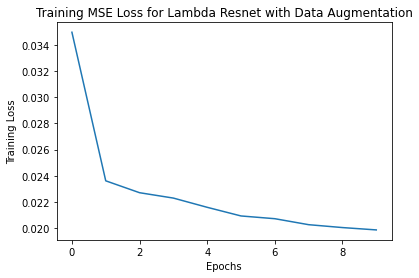

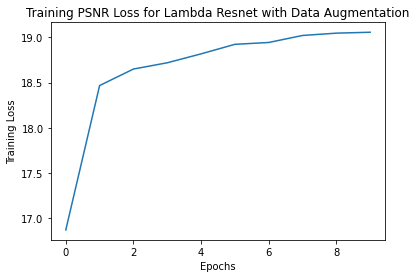

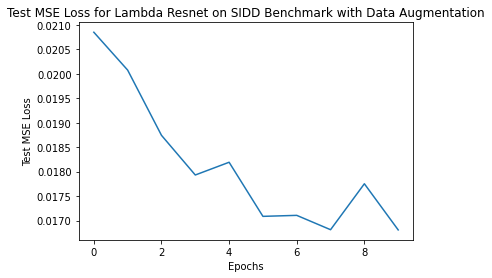

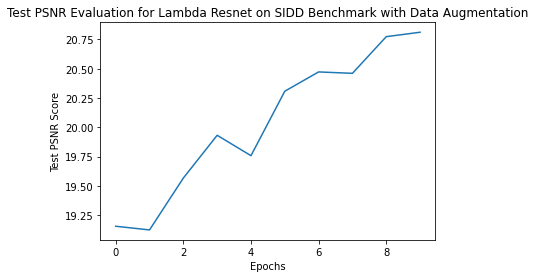

In [ ]:
epochs = [i for i in range(0, num_epochs)]
plt.plot(epochs, trn_loss)
plt.title("Training MSE Loss for Lambda Resnet with Data Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

plt.plot(epochs, trn_psnr)
plt.title("Training PSNR Loss for Lambda Resnet with Data Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()


plt.plot(epochs, tst_loss)
plt.title("Test MSE Loss for Lambda Resnet on SIDD Benchmark with Data Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Test MSE Loss")
plt.show()

plt.plot(epochs, tst_psnr)
plt.title("Test PSNR Evaluation for Lambda Resnet on SIDD Benchmark with Data Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Test PSNR Score")
plt.show()